<a href="https://colab.research.google.com/github/jiananwu72/Defect-Detection/blob/main/PyroscopyDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pyNSID sidpy SciFiReaders nanonispy gwyfile pycroscopy wget ipympl
!pip install numpy==1.24.4

In [ ]:
import wget
wget.download(url='https://zenodo.org/record/8190744/files/bfo_iv_final.hf5?download=1',
              out = 'bfo_iv_final.hf5')
wget.download(url='https://zenodo.org/record/8190744/files/bto_atomic.dm3?download=1',
              out = 'bto_atomic.dm3')

colab = True #Set to True if in Google Colab, else set to False
if colab:
    %matplotlib widget
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    %matplotlib notebook
#     %gui qt

Load packages and files

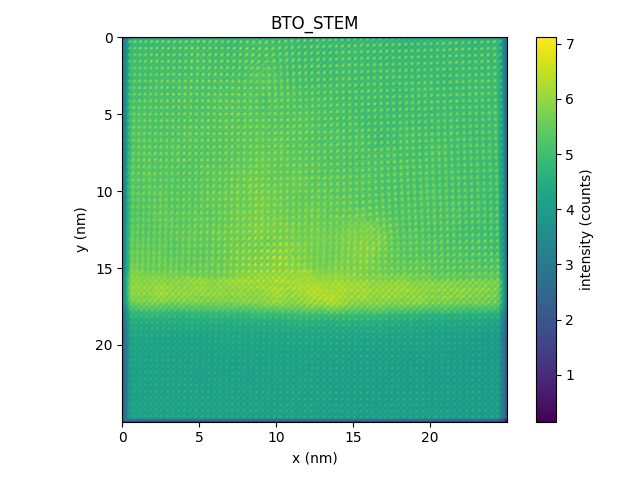

In [ ]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pyNSID

import sidpy as sid
import SciFiReaders as sr
from sidpy.proc.fitter import SidFitter
import warnings
warnings.filterwarnings('ignore')

dm3_file = r'bto_atomic.dm3'

dm3_reader = sr.DM3Reader(dm3_file)

data = dm3_reader.read()["Channel_000"]

data.title = 'BTO_STEM'
data._axes[0].quantity = 'x'
data._axes[1].quantity = 'y'
data.plot();

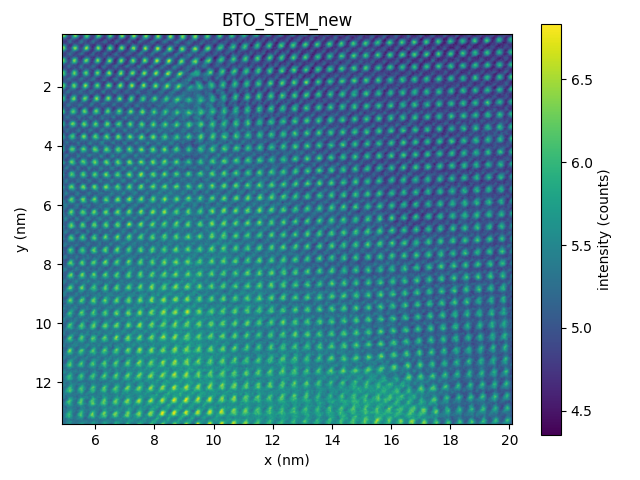

In [6]:
#Let's crop the image
data_cropped = data[200:-200,10:550]

fig = data_cropped.plot();

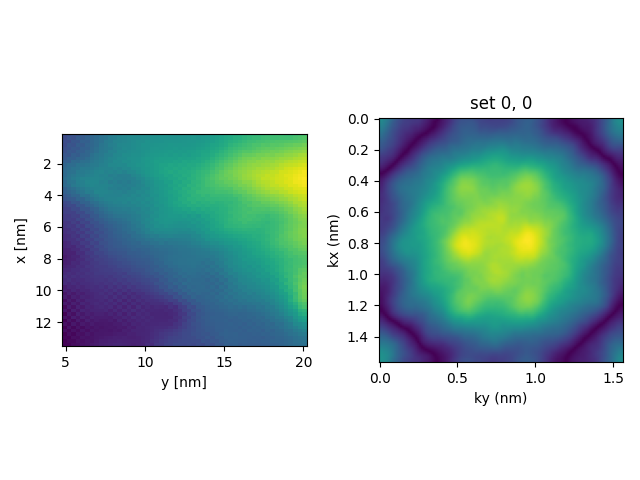

In [93]:
from pycroscopy.image import ImageWindowing

parms_dict = {}
parms_dict['window_step_x'] = 8
parms_dict['window_step_y'] = 8
parms_dict['window_size_x'] = 128
parms_dict['window_size_y'] = 128
parms_dict['mode'] = 'image'
parms_dict['filter'] = 'hamming'
parms_dict['zoom_factor'] = 2
parms_dict['interpol_factor'] = 2
iw = ImageWindowing(parms_dict)
windows = iw.MakeWindows(data_cropped)
windows = np.abs(np.log(np.abs(windows)))
windows.plot();

In [50]:
from pycroscopy.learn.ml.matrix_factor import MatrixFactor
mfactor = MatrixFactor(np.abs(windows), method = 'nmf',n_components = 3, return_fit = True)
output = mfactor.do_fit()

using generic parameters for dimension  1
using generic parameters for dimension  0


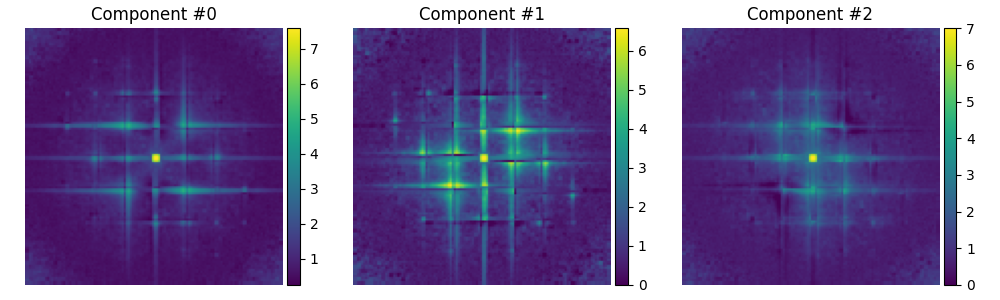

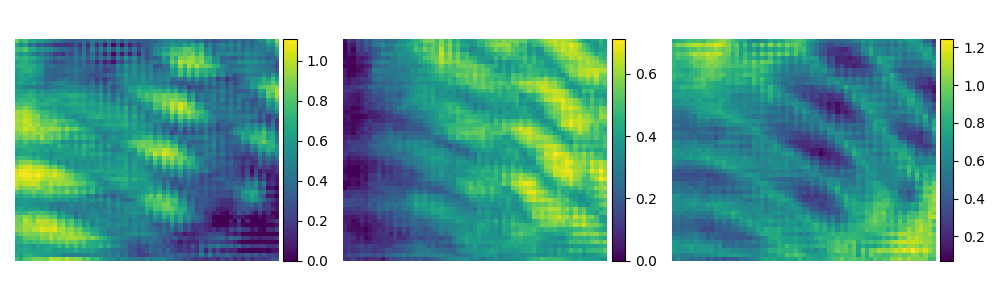

In [51]:
abundances = output[0]
components = output[1]
abund = np.array(abundances)
comps = np.array(components)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(nrows=1, ncols=mfactor.ncomp, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    im1 = ax.imshow(comps[ind,:,:])
    ax.set_title('Component #' + str(ind))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax.axis('off')
fig.tight_layout()
fig.savefig('Fig3b.png', dpi = 300)


fig, axes = plt.subplots(nrows=1, ncols=mfactor.ncomp, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    im1 = ax.imshow(abund[:,:,ind])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax.axis('off')

fig.tight_layout()
fig.savefig('Fig3c.png', dpi = 300)

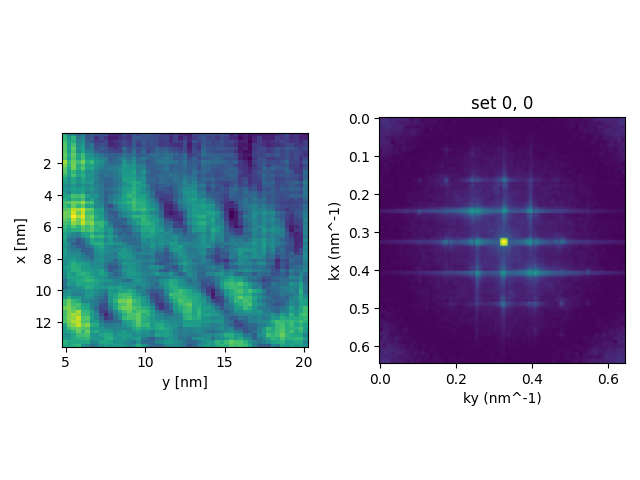

In [56]:
fit_dset = output[2]
fit_dset.plot()

In [66]:
nx, ny, wx, wy = fit_dset.shape
orig_x, orig_y = data_cropped.shape
recon   = np.zeros((orig_x, orig_y), dtype=float)
counter = np.zeros_like(recon)
fit_flat = fit_dset.fold(method = 'spa')
fit_flat

sidpy.Dataset of type IMAGE_4D with:
 dask.array<reshape, shape=(3339, 128, 128), dtype=float32, chunksize=(3339, 78, 128), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
a:  generic (generic) of size (3339,)
b:  generic (generic) of size (128,)
c:  generic (generic) of size (128,)
 with metadata: ['experiment', 'window_step_x', 'window_step_y', 'window_size_x', 'window_size_y', 'mode', 'filter', 'zoom_factor', 'interpol_factor', 'fft_mode', 'Matrix_Factorization', 'fold_attr']

In [94]:
np.array(fit_flat).shape

(3339, 128, 128)

In [130]:
import sidpy

W       = np.array(fit_dset)              # shape (nx, ny, wx, wy), complex
nx, ny, wx, wy = W.shape
W_flat  = np.array(fit_dset.fold(method = 'spa'))          # (n_windows, wx, wy)
pos_vec = iw.pos_vec.astype(int)          # (n_windows, 2)
F       = iw.filter_mat                   # (wx, wy)

# 2) prepare accumulators
X, Y      = iw.image_shape
recon_sum = np.zeros((X, Y), dtype=float)
weight_sum= np.zeros((X, Y), dtype=float)

# 3) overlap‐add with Hamming weighting
for idx, patch_fft in enumerate(W_flat):
    x0, y0    = pos_vec[idx]
    # undo fftshift and invert
    patch_ifft = np.fft.ifftshift(patch_fft)
    patch_real = np.real(np.fft.ifft2(patch_ifft))
    # accumulate
    recon_sum [ x0:x0+wx, y0:y0+wy ] += patch_real * F
    weight_sum[ x0:x0+wx, y0:y0+wy ] += F

# 4) normalize
recon = recon_sum / np.where(weight_sum>0, weight_sum, 1)

reconstruction = sidpy.Dataset.from_array(np.abs(np.log(recon)), name='recon')
reconstruction.data_type = 'image'
reconstruction.set_dimension(0, sidpy.Dimension(np.arange(reconstruction.shape[0]),
                                          name='x', units='nm', quantity='x',
                                          dimension_type='spatial'))
reconstruction.set_dimension(1, sidpy.Dimension(np.arange(reconstruction.shape[1]),
                                          name='y', units='nm', quantity='y',
                                          dimension_type='spatial'))

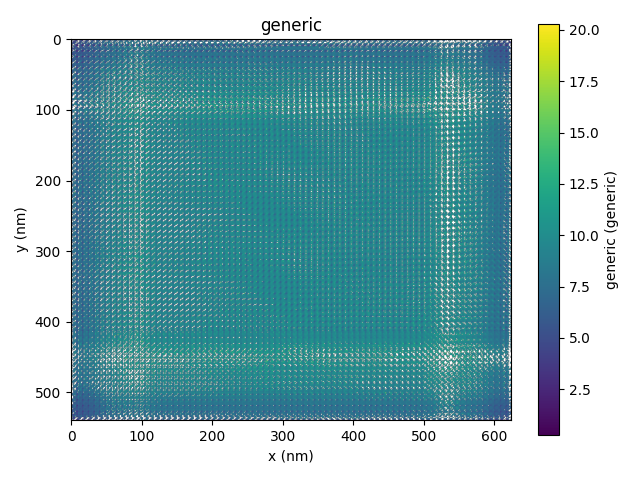

In [131]:
reconstruction.plot();